In [1]:
# %matplotlib widget

from pyCascade import geomCreate as gC
from pyCascade import probeSetup, physics
from solid2 import *
import numpy as np
from matplotlib import pyplot as plt
import pandas
import os
from stl import mesh
from mpl_toolkits import mplot3d

# scratch_dir = pathlib.Path().absolute()
category =  "config2"
run = 1

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)

geom_write = True
probe_write = True

'/scratch/users/nbachand/Cascade/city_block_cfd'

In [2]:
x = 4
y = 3
z = 4
wthick = .001*np.min([x,y,z])
nx=3
ny=1
nz=2
roof_height = y
house_grid = [12,8]
house_spacing = [4*x,6*z]
interior_house = (6,4)
interior_house_skylights = (5,4)
odd_offset = [2*z, 0]

house_dims = [nx*x, ny*y + roof_height, nz*z]
house_seperation = [house_spacing[0]-house_dims[0], 0, house_spacing[1]-house_dims[2]]

domain_size = [house_grid[d]*house_spacing[d] for d in [0,1]]
domain_height = max(domain_size) / 3
# domain_height = (max(domain_size) + ny*y + roof_height) / np.pi
domain_size.insert(1, domain_height)

print(domain_size)


[192, 64.0, 192]


Vertical Profiles

In [3]:
Ly = domain_height
n_stack_floor = int(Ly+1)
n_stack_roof = int(Ly-(house_dims[1]))

probe_cols = { 
    (9,2): (house_dims[0]/2, -house_seperation[2]/2, [0, Ly], n_stack_floor), # between z
    (3,6): (-house_seperation[0]/2, house_dims[2]/2, [0, Ly], n_stack_floor), # between x
    (3,2): (-house_seperation[0]/2, -house_seperation[0]/2, [0, Ly], n_stack_floor), # between x z
    (9,6): (house_dims[0]/2, house_dims[2]/2, [house_dims[1], Ly], n_stack_roof) # roof
}

In [4]:
rooms, rooms_params = gC.makeRooms(x,y,z,wthick,nx,ny,nz)
rooms_params = gC.identify_openings(rooms_params)
rooms_params['door_locations'] = [[1,1,'x']]
rooms_params['window_locations'].remove([2,0,'x'])
rooms_params['window_locations'].remove([2,1,'x'])
rooms_params['wall_locations'] = [[2,1,'z']]

In [5]:

house_list = []
house_coordinates = {}

nxhouses = range(-(odd_offset[0]>0),house_grid[0] + (odd_offset[0]<0))
nzhouses = range(-(odd_offset[1]>0),house_grid[1] + (odd_offset[1]<0))

house_coordinate = {}

for i in nxhouses:
    exterior = gC.ProbedGeom(cube([nx*x, ny*y, nz*z]))
    roof = gC.makeRoof(x*nx, x*nx*2/3, z*nz, 0, roof_height, y*ny)
    doors = gC.makeDoors(rooms_params, y*.25, y*.75, 10, 10)
    windows = gC.makeWindows(rooms_params, y*.25, y*.25, 10, 10)
    walls = gC.openWalls(rooms_params, z-2*wthick, y-2*wthick, 0, 0)
    skylights = gC.makeSkylights(rooms_params, y*.25, y*.25, 10, 10)
    skylights.translate((0,0.1,0))
    for k in nzhouses:
        if (i,k) == interior_house:
            house = exterior+roof-rooms-doors-windows-walls
        elif (i,k) == interior_house_skylights:
            house = exterior+roof-rooms-doors-windows-walls-skylights
            house.append_names("skylights")
        else:
            house = exterior+roof
        if (i, k) in probe_cols:
            house.probes += [{
                "name": f"col_{i}-{k}",
                "tile": probeSetup.y_col(*probe_cols[(i, k)])
            }]
        del_x = (house_spacing[0]-x*nx)/2 + odd_offset[0]*(k%2) + i*house_spacing[0]
        del_z = (house_spacing[1]-z*nz)/2 + odd_offset[1]*(i%2) + k*house_spacing[1]
        house_coordinate =  [del_x, 0, del_z]
        house.translate(house_coordinate)
        house_coordinates[(i,k)] =  house_coordinate
        house_list.append(house)
        house_coordinates[i, k] = [del_x, 0, del_z]

houses = gC.sumProbedGeom(house_list)

domain = gC.ProbedGeom(cube(domain_size))

neighborhood = domain - houses

geom_path = f"{home_dir}/city_block_geom/OpenSCAD/{category}"
if geom_write: scad_render_to_file(neighborhood.geom, f"{geom_path}/mesh_geom.scad")
print(len(neighborhood.probes))

if geom_write: scad_render_to_file(houses.geom, f"{geom_path}/houses.scad")
open_space = gC.ProbedGeom(cube((domain_size[0], 2*y, domain_size[2])))
open_space.translate((0, .9*y, 0))
open_houses = houses - open_space
if geom_write: scad_render_to_file(open_houses.geom, f"{geom_path}/open_houses.scad")


30


Window Probes

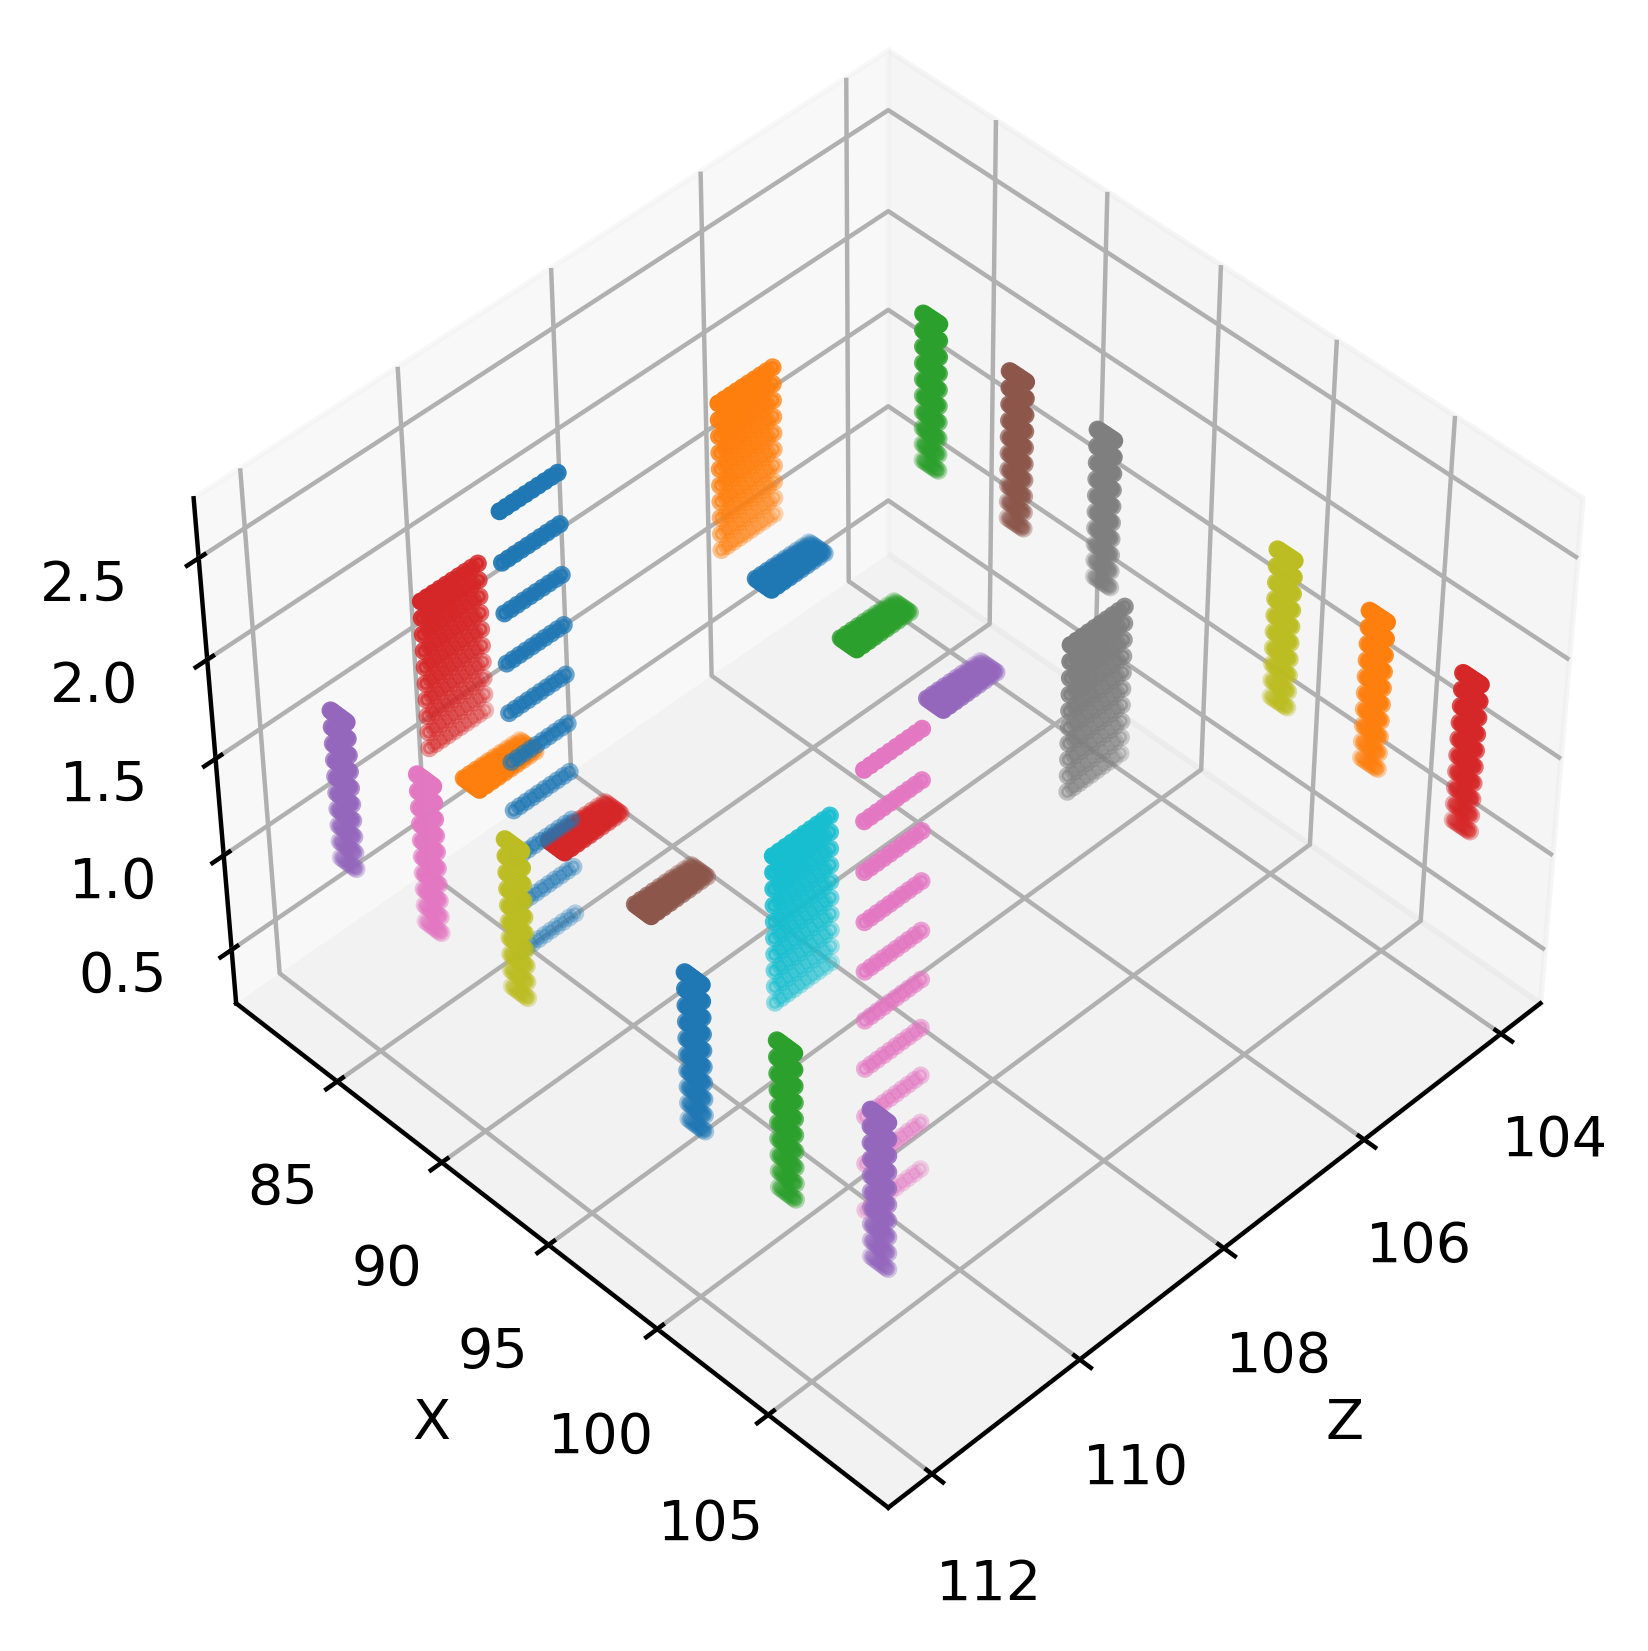

In [6]:
fig = plt.figure(dpi=400)
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

for p in neighborhood.probes:
    if "col" not in p["name"]:
        ax.scatter(p["tile"][:,0], p["tile"][:,1], p["tile"][:,2], marker='.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=45, azim=45, roll=0, vertical_axis='y')
# plt.axis('square')

plt.show()

if probe_write: neighborhood.write_probes(f"{scratch_dir}/CHARLES/{category}/R{run}/probes/locations/")

In [7]:
# for p in neighborhood.probes:
#     name = p['name']
#     print(f"POINTCLOUD_PROBE NAME=probes/probesOut/{name} INTERVAL=1 PRECISION=FLOAT FORMAT=FLOAT GEOM=FILE probes/locations/{name}.txt   VARS=comp(u,0) comp(u,1) comp(u,2)")

FileNotFoundError: [Errno 2] No such file or directory: '/home/users/nbachand/Cascade/city_block_cfd/city_block_geom/OpenSCAD/config2/houses.stl'

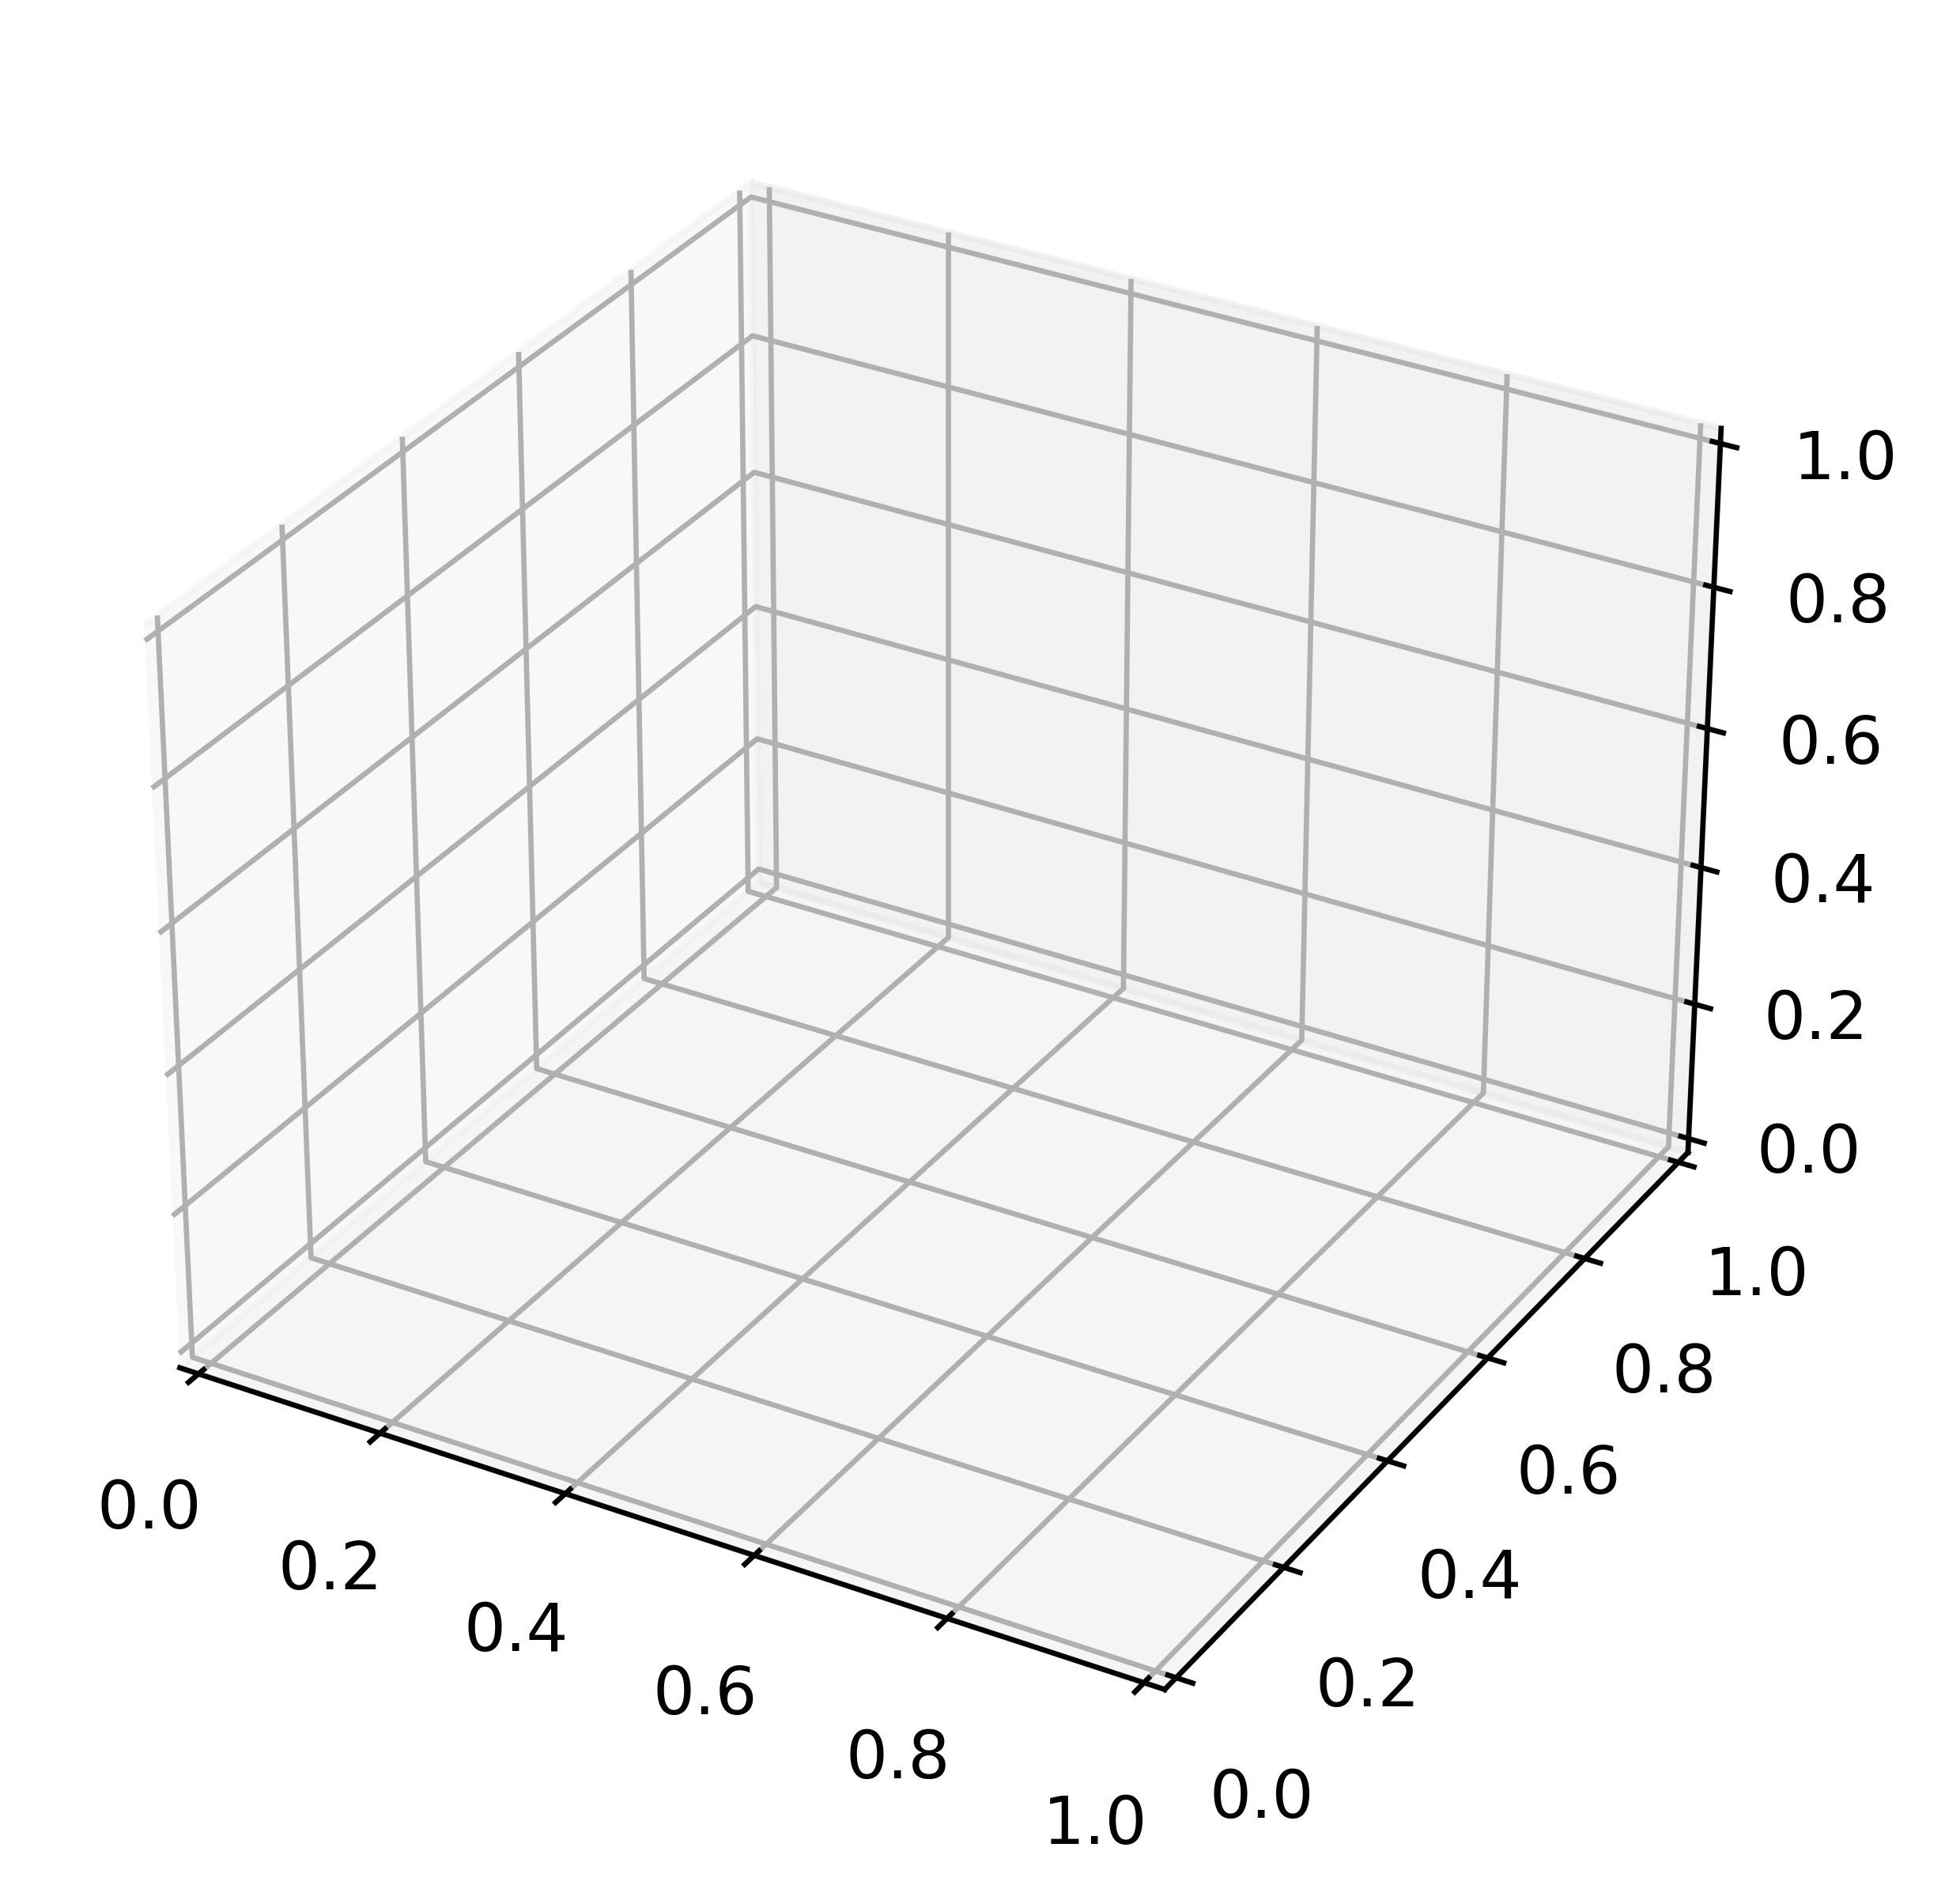

In [8]:
figure = plt.figure(dpi = 600)
ax = figure.add_subplot(projection='3d')

# plot_vectors[...,1] = geom_stl.vectors[...,2]
# plot_vectors[...,2] = geom_stl.vectors[...,1]

# Load the STL files and add the vectors to the plot
geom_stl = mesh.Mesh.from_file(f"{geom_path}/houses.stl")

plot_vectors = geom_stl.vectors
ax.add_collection3d(mplot3d.art3d.Poly3DCollection(plot_vectors))

# Auto scale to the mesh size
scale = geom_stl.points.flatten()
ax.auto_scale_xyz(scale, scale, scale)

for p in neighborhood.probes:
    if "col" in p["name"]:
        ax.scatter(p["tile"][:,0], p["tile"][:,1], p["tile"][:,2], marker=".", s=(172./figure.dpi)**2, label = p["name"])

# Show the plot to the screen
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')                                                                                                  
ax.view_init(elev=60, azim=30, roll=0, vertical_axis='y')
plt.legend()
plt.show()

# figure.savefig(f"{geom_path}/houses")

In [9]:
house_coordinates[(interior_house)]

[98.0, 0, 104.0]

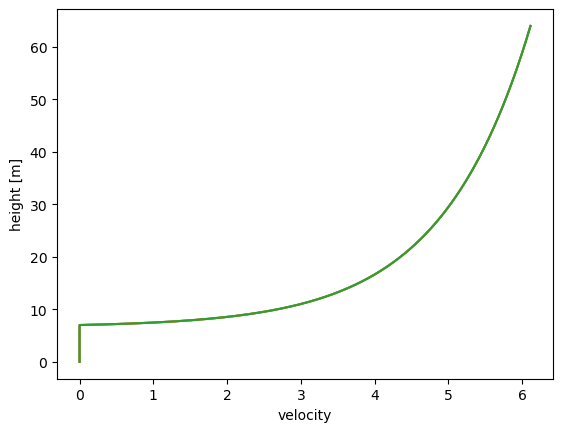

In [10]:
vK_const = .41
hm = 6
rho = 1.225
mu = 1.7894e-5
# Re_tau = 43300
Lz =  domain_height
z_ref = 10 # really y_ref
U_ref = 4

z_0 = 0.061*hm #used for convention, but really y_0
disp = 1.11*hm
shear_vel = vK_const*U_ref/np.log(z_ref/z_0)

plt.figure()
LES_params = {
    'uStar': shear_vel,
    'z0': z_0,
    'disp': disp,
    'Dt': .01,
    'z_values' : np.linspace(0,Lz,10000)
}
physics_setup = physics.LES_Physics(LES_params)
physics_setup.plot_log_wind()

# checking against charles code
# approximate log law mean profile
y_scaled = (LES_params['z_values']-disp)/z_0
y_scaled = np.maximum(1.0, y_scaled)
ux = (shear_vel/vK_const)*np.log(y_scaled)

# physics_setup.plot_log_wind()

plt.plot(ux, LES_params['z_values'])
plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

u_bulk is 4.39937061769926
domain height is 64.0
u_bulk is 4.411350169457111
domain height is 64.0


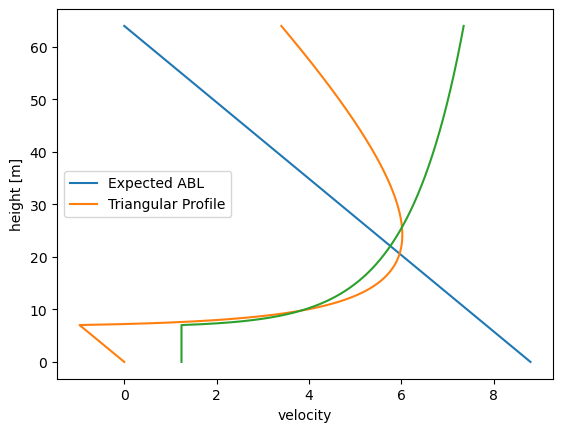

TypeError: unsupported operand type(s) for -: 'list' and 'float'

In [14]:
physics_setup.plot_spinup_velocity()

# physics_setup.LES_params['spinup_profile']

# plt.plot(ux, LES_params['z_values'])

# plt.plot(2*ux - np.flip(spinup_profile), LES_params['z_values'])

physics_setup.plot_spinup_velocity2()

plt.legend(('Expected ABL', 'Triangular Profile', "Nick's Spinnup"))

plt.plot(ux+2.5*physics_setup.LES_params['uStar'], LES_params['z_values'])

plt.show()

y_ref = 0.9 * domain_height
u_t = physics.loglaw_with_disp([y_ref], physics_setup.LES_params['uStar'], physics_setup.LES_params['z0'], physics_setup.LES_params['disp'])

In [ ]:
physics_setup.calc_flatplate_quantities(
    rho = 1.224,
    mu = 1.7894e-5,
    yPlus = 500
    )

In [ ]:
wall_spacing = y/10*2 #physics_setup.LES_params['flatplate']['spacingW']*10
growth_rate = 1.1
a = (growth_rate-1)/growth_rate
level_heights = []
level_height = 0
level_up = 0

while level_height < domain_height:
    level_height = wall_spacing*(2**level_up -1)/a
    level_heights.append(level_height)
    level_up += 1

n_levels = level_up-2
display(f"Number of refinement levels is {n_levels}") # not counting level 0

hcp_delta = wall_spacing*2**(n_levels)

for i in range(1, n_levels+1):
    level = n_levels+1-i
    height = round(level_heights[i], 1)
    del_height = round(height - level_heights[i-1],1)
    display(f'Level {level} has height {height} and spans {del_height}')
    level_hcp_delta = hcp_delta/2**(level-1)
    display(f'NLAYES is {del_height/level_hcp_delta}')

display(f'hcp delta is {hcp_delta} for wall spacing {wall_spacing} and domain height {domain_height}')

In [ ]:
# hcp_delta = 9.6
# n_std = 1
# U_ref = physics_setup.LES_params['log_wind']
# U_ref += n_std*(2.5*physics_setup.LES_params['uStar'])
# z_levels = []
# n = 5
# for level in range(n):
#     U_level = U_ref[-1]/(2**level)
#     ind_level = np.argmin(np.abs(U_ref-U_level))
#     z_level = physics_setup.LES_params['z_values'][ind_level]
#     z_levels.append(z_level)

#     display(f'level {level} is at {z_level} with velocity of velocity {U_level}')

# z_levels.append(0)
# for level in range(n):
#     h_level = z_levels[level] - z_levels[level+1]
#     cell_size = hcp_delta/(2**level)
#     h_level = np.max((h_level, 5*cell_size))
#     h_level = np.round(h_level, 0)
#     display(f'level {level} has height of {h_level}')

# display(f'ground mesh size is {cell_size}')

In [ ]:
P0 = 0.6
r = 1.1
y = np.linspace(0, 100, 1000)
s = np.zeros_like(y)
h = np.zeros_like(y)
s[0] = P0
h[0] = P0

h_an = np.zeros_like(y)

for i in range(1, len(y)):
    s[i] = s[i-1]*r
    h[i] = h[i-1] + s[i]
    if h[i] > y[-1]:
        break
plt.scatter(s,h)
plt.plot(P0+(r-1)/r*y, y)

In [ ]:
# write a function that reads text, looks for three consecutive numbers, and multiplies them by scaling factors
def scale_text(text, scale_factors):
    text = text.split(' ')
    for i in range(len(text)-2):
        try:
            for j in [i, i+1, i+2]:
                float(text[j])
            for j in [i, i+1, i+2]:
                text[j] = float(text[j])
                text[j] *= scale_factors[j-i]
                text[j] =   f'{round(text[j], 1):.1f}'
                text[j] = text[j].replace('.0', '')
        except:
            pass
    text = ' '.join(map(str, text))
    return text

# read text from file and preserve line breaks
with open(f"{scratch_dir}/CHARLES/{category}/R{run}/charles.in", 'r', newline = '') as f:
    text = f.read()
text = scale_text(text, [4/3,1,4/3])
print(text)
